In [1]:
%matplotlib inline 

# Association Rule Mining
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Association Rule Mining on the Instacart Data

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [4]:
te = TransactionEncoder()

In [5]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

In [6]:
orders = read_csv_file(my_orders_file)
orders.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12202,472199,765,prior,1,2,21,NaN
1,12203,1424394,765,prior,2,1,21,20.0
2,12204,889292,765,prior,3,6,21,30.0
3,12205,2809253,765,prior,4,3,20,30.0
4,12206,2392861,765,prior,5,1,12,19.0


In [7]:
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,147221,15511,429,1,0
1,147222,15511,46397,2,0
2,147223,15511,27323,3,0
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0


In [8]:
products = read_csv_file(products_file)
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
departments = read_csv_file(departments_file)
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
aisles = read_csv_file(aisles_file)
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Product Number Counts

In [11]:
product_order_frequency = (orders_products
                           .groupby("product_id")
                           .size()
                           .reset_index(name="count")
                           .sort_values(by=['count'], ascending=False)
                          )
order_count_total = orders.shape[0]
print("Total Orders :", order_count_total)
max_product_count = product_order_frequency["count"].max()
min_product_count = product_order_frequency["count"].min()
print("Product Order Count Max :", max_product_count)
print("Product Order Count Min :", min_product_count)
mean_order_frequency = round(product_order_frequency["count"].mean())
print("Product Order Count Average :", mean_order_frequency)
print("Product Order Count Median :", product_order_frequency["count"].median())
print("Product Order Count Mode :", product_order_frequency["count"].mode()[0])

Total Orders : 306
Product Order Count Max : 67
Product Order Count Min : 1
Product Order Count Average : 3.0
Product Order Count Median : 1.0
Product Order Count Mode : 1


### Grouping Products in an Order

In [12]:
# Can't just use a comma as a seperator
products_ordered = orders_products.merge(products, on="product_id")
weird_separator = ",#,"
group = products_ordered.groupby('order_id')
product_count = group.size().reset_index(name="count")
product_names = group["product_name"].apply(lambda x: "%s" % weird_separator.join(x)).reset_index(name="products")
products_ordered_total = (product_count.merge(product_names, on="order_id"))
order_total = products_ordered_total.shape[0]
products_ordered_total.head()

,order_id,count,products
0,15511,13,"Dark Red Kidney Beans,#,Reduced Sodium Great N..."
1,22082,3,"Organic Extra Large Brown Eggs,#,Organic Fruit..."
2,26712,14,"Gluten Free Breaded Chicken Breast Tenders,#,1..."
3,27068,14,"Yellow Onions,#,Red Peppers,#,Yellow Bell Pepp..."
4,49162,9,"Bunched Cilantro,#,Red Peppers,#,Yellow Bell P..."


### Calculate Decent Support Value

In [13]:
# For support values
# Suck it and see approach to get min desired appearance
min_desired_times_ordered = 10
min_support = round(min_desired_times_ordered/order_total, 4)
print("Minimum times ordered to be considered :", min_desired_times_ordered)
print("Minimum Support :", min_support)

Minimum times ordered to be considered : 10
Minimum Support : 0.0331


### Transaction Database Boolean Array

In [14]:
products_ordered_list = products_ordered_total.products.tolist()
products_ordered_list_of_lists = []
for p in products_ordered_list:
    products_ordered_list_of_lists.append(p.split(weird_separator))
te_ary = te.fit(products_ordered_list_of_lists).transform(products_ordered_list_of_lists,sparse=False)
te_df = pd.DataFrame(te_ary, columns=te.columns_)
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,Yellow Peaches,YoBaby Peach Pear Yogurt,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry",Yobaby Organic Plain Yogurt,Yogurt Tubes Blueberry,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,ZBar Organic Chocolate Brownie Energy Snack,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## First 100 transactions vs items

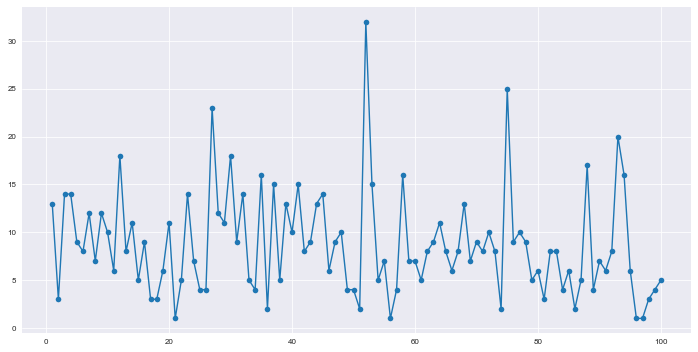

In [15]:
limit = 100
the_range = list(range(1, limit + 1))
fig = plt.figure()
ax = plt.axes()
ax.plot(the_range, products_ordered_total["count"].head(limit), "-o");

## Distribution of Transaction size

In [16]:
# Generate plot of count of the number of transactions of the same size
a = (products_ordered_total[["count"]]
     .groupby("count")
     .size()
     .reset_index(name="counts")
     .sort_values(by="counts", ascending=False)
    )
a.head()

,count,counts
8,9,28
4,5,25
7,8,22
9,10,22
2,3,21


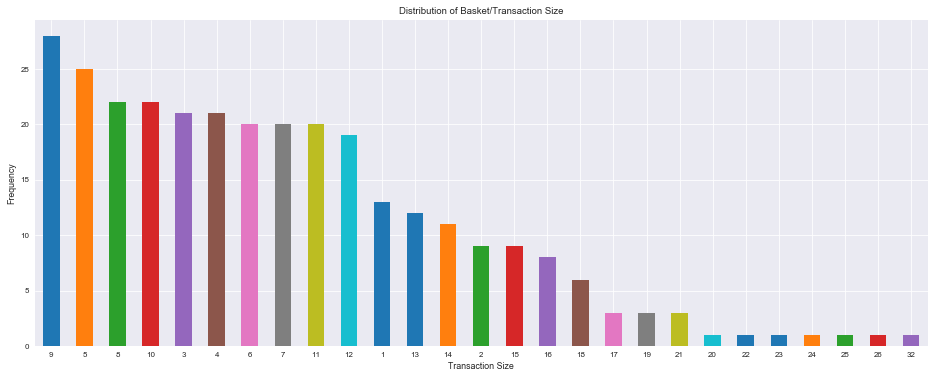

In [17]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(16)
a['counts'].plot.bar()
ax.set_xticklabels(a["count"], rotation='horizontal')
plt.title("Distribution of Basket/Transaction Size")
plt.ylabel("Frequency")
plt.xlabel("Transaction Size")
plt.show()

## Frequent Itemsets - Apriori

In [18]:
frequent_itemsets = (apriori(te_df, min_support=min_support,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0331  support : 121


,support,itemsets
1,0.221854,[2% Reduced Fat Organic Milk]
46,0.175497,[Vanilla Almond Breeze]
64,0.165563,"[2% Reduced Fat Organic Milk, Vanilla Almond B..."
11,0.139073,[Granny Smith Apples]
2,0.129139,[Banana]


### Support for most Frequeny products

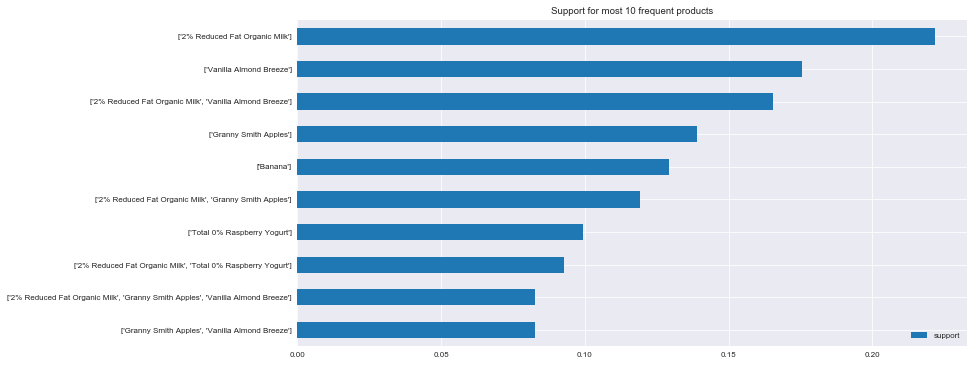

In [19]:
min_numer_to_show = 10
frequent_itemsets.head(min_numer_to_show).plot.barh(title ="Support for most " + str(min_numer_to_show) +  " frequent products")
plt.yticks(range(min_numer_to_show), frequent_itemsets["itemsets"].head(min_numer_to_show))
plt.gca().invert_yaxis()
plt.show()

## Rule Generation

####  Rule Generation by Lift

In [20]:
min_lift = 5
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head()

Number of Generated Rules via lift : 154  min value of lift :  5


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
39,(Total 2% Greek Strained Yogurt with Cherry 5....,(Vanilla Almond Breeze),0.043046,0.175497,0.043046,1.0,5.698113,0.035492,inf
50,(Total 2% Greek Strained Yogurt with Cherry 5....,(Vanilla Almond Breeze),0.039735,0.175497,0.039735,1.0,5.698113,0.032762,inf
76,(Total 2% Lowfat Greek Strained Yogurt With Bl...,(Total 0% Raspberry Yogurt),0.039735,0.099338,0.039735,1.0,10.066667,0.035788,inf
80,(Total 2% Lowfat Greek Strained Yogurt With Bl...,(Total 0% Raspberry Yogurt),0.039735,0.099338,0.039735,1.0,10.066667,0.035788,inf
82,(Total 2% Lowfat Greek Strained Yogurt With Bl...,"(2% Reduced Fat Organic Milk, Total 0% Raspber...",0.039735,0.092715,0.039735,1.0,10.785714,0.036051,inf


#### Rule Generation by Confidence

In [21]:
min_conf = 0.8
conf_rules = (association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
        .sort_values(by='confidence',ascending=False))
print ("Number of Generated Rules via confidence :", conf_rules.shape[0], " min confidence :", min_conf)
conf_rules.head()

Number of Generated Rules via confidence : 85  min confidence : 0.8


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
27,(Total 2% Greek Strained Yogurt with Cherry 5....,(Vanilla Almond Breeze),0.043046,0.175497,0.043046,1.0,5.698113,0.035492,inf
65,(Premium Lager Beer),(Lager),0.036424,0.039735,0.036424,1.0,25.166667,0.034977,inf
25,"(Cherry Pomegranate Greek Yogurt, Total 0% Ras...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
26,"(Vanilla Almond Breeze, Total 2% Greek Straine...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
55,(Total 2% Lowfat Greek Strained Yogurt With Bl...,"(2% Reduced Fat Organic Milk, Total 0% Raspber...",0.039735,0.092715,0.039735,1.0,10.785714,0.036051,inf


In [22]:
# get stats on objective measures
lift_rules[["support","confidence", "lift"]].describe()

,support,confidence,lift
count,154.000000,154.000000,154.000000
mean,0.039305,0.605803,8.286147
std,0.005700,0.231916,2.640499
min,0.033113,0.188679,5.136054
25%,0.033113,0.428571,6.990741
50%,0.039735,0.579832,8.217687
75%,0.043046,0.833333,9.378882
max,0.059603,1.000000,25.166667


In [23]:
conf_rules[["support","confidence", "lift"]].describe()

,support,confidence,lift
count,85.000000,85.000000,85.000000
mean,0.044916,0.918861,6.750995
std,0.019121,0.064391,3.701165
min,0.033113,0.800000,3.863539
25%,0.036424,0.857143,4.507463
50%,0.039735,0.923077,5.259797
75%,0.043046,1.000000,8.988095
max,0.165563,1.000000,25.166667
